# Exploring the impact of flight on the perceived distance between Sydney and Australia

This notebook explores whether Trove's digitised newspapers can be used to extract information about how our perception of distance has changed over time, particularly as a result of the impact of aviation. For more details, [see Brett's blog post](https://heritageoftheair.org.au/blog/uncategorized/breaking-the-tyranny-of-distance/).

The basic methodology was:

* We experimented with a variety of Trove newspaper searches to find articles that included place names (such as 'Sydney' and 'London') and a unit ot time (such as 'days').
* We found that a search in the [title for 'London' and 'Sydney' and either 'day' or 'days'](https://trove.nla.gov.au/newspaper/result?q=title%3A%28%28london+sydney%29%2B%28day+OR+days%29%29) seemed to produce the most relevant results.
* We fed this query to the [Trove newspaper harvester](trove-newspaper-harvester/Using-TroveHarvester-to-get-newspaper-articles-in-bulk.ipynb) and downloaded the details of all matching articles. When we first tried this, 1373 articles matched the query. The most recent harvest returned 1391 articles. Data from the harvests are included in the `trove-newspaper-harvester/data` directory. 
* We used regular expressions and the [word2number](https://pypi.org/project/word2number/) library to extract numbers that appear up to five words before the words 'day' or 'days' in the titles of the newspaper articles.
* The number of days was added to the article metadata and saved as [a CSV file](articles_with_days.csv).
* In our first experiments we didn't attempt any cleaning of the data. This notebook does, however, add some basic checking and cleaning. The cleaned results were saved as [another CSV file](articles_with_days_edited.csv).
* We then attempted some simple visualisations to show how the number of days changed over time.

## Import what we need

In [1]:
import pandas as pd
import os
import re
import altair as alt
from altair import datum
from word2number import w2n
import numpy as np
from pathlib import Path
import json
import arrow

## Open data from the Trove newspaper harvest

As noted, the harvested data is stored in the `trove-newspaper-harvester/data`. These functions help us find and load data from a particular harvest.

In [2]:
def list_harvests():
    '''
    Provides a short summary of available harvests.
    '''
    for harvest in sorted(Path('trove-newspaper-harvester/data').iterdir()):
        if harvest.name.isdigit():
            metadata_file = harvest / 'metadata.json'
            metadata = json.loads(metadata_file.read_text())
            df = pd.read_csv(harvest / 'results.csv', parse_dates=['date'])
            print(f'Harvest id: {harvest.name}')
            print(f'Date of harvest: {arrow.get(metadata["date_started"]).format("D MMM YYYY")}')
            print(f'Query: {metadata["query"]}')
            print(f'Number of articles: {df.shape[0]}')
            print(f'Date range: {df["date"].min().year} - {df["date"].max().year}\n')

def get_latest_harvest():
    '''
    Get the timestamp of the most recent harvest.
    '''
    harvests = sorted([d for d in os.listdir('trove-newspaper-harvester/data') if os.path.isdir(os.path.join('trove-newspaper-harvester/data', d))])
    return harvests[-1]

def open_harvest_data(timestamp=None):
    '''
    Open the results of the specified harvest (most recent by default).
    Returns a DataFrame.
    '''
    if not timestamp:
        timestamp = get_latest_harvest()
    print(timestamp)
    df = pd.read_csv(os.path.join('trove-newspaper-harvester/data', timestamp, 'results.csv'), parse_dates=['date'])
    return df 

List all the harvests in the `data` directory.

In [3]:
list_harvests()

Harvest id: 1543809004
Date of harvest: 3 Dec 2018
Query: https://trove.nla.gov.au/newspaper/result?q=title%3A%28london+sydney+days%29
Number of articles: 604
Date range: 1859 - 1953

Harvest id: 1543895876
Date of harvest: 4 Dec 2018
Query: https://trove.nla.gov.au/newspaper/result?q=title%3A%28london+darwin+days%29
Number of articles: 237
Date range: 1871 - 1938

Harvest id: 1543899129
Date of harvest: 4 Dec 2018
Query: https://trove.nla.gov.au/newspaper/result?q=title%3A%28london+sydney+hours%29
Number of articles: 176
Date range: 1872 - 1973

Harvest id: 1543900377
Date of harvest: 4 Dec 2018
Query: https://trove.nla.gov.au/newspaper/result?q=title%3A%28london+melbourne+hours%29
Number of articles: 90
Date range: 1888 - 1953

Harvest id: 1543900880
Date of harvest: 4 Dec 2018
Query: https://trove.nla.gov.au/newspaper/result?q=title%3A%28sydney+perth+hours%29
Number of articles: 114
Date range: 1890 - 1969

Harvest id: 1544092506
Date of harvest: 6 Dec 2018
Query: https://trove.nla.

We want the most recent harvest, so using the `Harvest id` we load the data as a Pandas DataFrame.

In [4]:
df = open_harvest_data('1572835205')

1572835205


In [23]:
df.head()

,article_id,title,newspaper_id,newspaper_title,page,date,category,words,illustrated,corrections,url,page_url,days
0,100239574,"TELEGRAMS. SYDNEY AND COLONIAL. SYDNEY, Monday, 4 p.m. THE heat to-day in the city is intense. BRITISH AND FOREIGN. LONDON, April 11.",367,Goulburn Herald (NSW : 1881 - 1907),3,1897-04-12,Article,91,N,0,https://nla.gov.au/nla.news-article100239574,http://trove.nla.gov.au/newspaper/page/9459345,NaN
1,100291026,"To-day's Wires THE KAISER'S OFFER. FOR BOMBS ON LONDON. Sydney, Tuesday, 9 a.m.",421,The Forbes Advocate (NSW : 1911 - 1954),2,1914-10-06,Article,142,N,0,https://nla.gov.au/nla.news-article100291026,http://trove.nla.gov.au/newspaper/page/10556442,NaN
2,100307730,"THE WAR TO-DAY'S CABLES ALLIED OFEENSIVE AT LAST Most Cheering News. (Reuter's and London ""Time Cables). Sydney, Friday.",421,The Forbes Advocate (NSW : 1911 - 1954),4,1918-07-19,Article,513,N,0,https://nla.gov.au/nla.news-article100307730,http://trove.nla.gov.au/newspaper/page/10558728,NaN
3,10063909,"EMPIRE DAY. ""DAILY MAIL "" CUP WON BY SYDNEY TEAM. LONDON, May 30.",10,"The Mercury (Hobart, Tas. : 1860 - 1954)",5,1910-05-31,Article,223,N,0,https://nla.gov.au/nla.news-article10063909,http://trove.nla.gov.au/newspaper/page/878811,NaN
4,101782815,"For London PREMIER AND FAMILY LEAVE TO-DAY SYDNEY, Monday.",418,"Southern Morning Herald (Goulburn, NSW : 1920 - 1923)",2 S,1923-01-16,Article,34,N,0,https://nla.gov.au/nla.news-article101782815,http://trove.nla.gov.au/newspaper/page/10644978,NaN


### Extract number of days from article titles

The following function looks at up to 5 words occuring before the string 'day' in the title of newspaper articles. It first attempts to turn those words into numbers using the [word2number](https://pypi.org/project/word2number/) library. However, word2number doesn't recognise the ½ character, so an additional regular expression is used to find these and add 0.5 to the number.

In [5]:
def get_numbers(title):
    '''
    Extract numbers that occur before the words 'day' or 'days' in the titles of newspaper articles.
    '''
    number = None
    try:
        # Get max of 5 words appearing before 'day'
        day_strs = re.findall(r'(?:\b\w+\b[\s\-\',]*){1,5}[\s\-]+day', title, flags=re.IGNORECASE)
        # print(day_strs)
    except:
        day_strs = []
    for day_str in day_strs:
        day_str = day_str.replace(',', '').replace('"', '')
        # print(day_str)
        try:
            number = float(w2n.word_to_num(day_str))
        except ValueError:
            # print(day_str)
            try:
                number = float(re.search(r'(\d+)[½]*[\s\-]+day', day_str, flags=re.IGNORECASE).group(1))
            except AttributeError:
                pass
        if number and (re.search(r'½[\s\-]+day', day_str, flags=re.IGNORECASE) or re.search(r'half[\s\-]+day', day_str, flags=re.IGNORECASE)):
            number = number + 0.5
    return number


Let's try a simple test to see how this works.

In [6]:
tests = [
    'Link with London Day and Night Air Services To Sydney in 7½ Days',
    "DAY GAINED WHEN FLYING WEST WITH SUN SYDNEY LONDON TRIP REDUCED TO 12 DAYS CAPT. BRAIN'S EXPLANATION. BRISBANE, Saturday.",
    'OFF TO LONDON! "THE SPIRIT OF AUSTRALIA" LEFT AT DAWN TO-DAY "London in Ten Days!" SYDNEY, Tuesday.',
    'THREE DAYS London-Sydney'
]
for test in tests:
    days = get_numbers(test)
    print(days)

7.5
12.0
10.0
3.0


Now we'll try to extract the number of days from all the articles in the dataset.

In [7]:
df['days'] = df['title'].apply(lambda x: get_numbers(x))
# df['days'] = pd.to_numeric(df['days'], errors='coerce')
df.head()

,article_id,title,newspaper_id,newspaper_title,page,date,category,words,illustrated,corrections,url,page_url,days
0,100239574,"TELEGRAMS. SYDNEY AND COLONIAL. SYDNEY, Monday...",367,Goulburn Herald (NSW : 1881 - 1907),3,1897-04-12,Article,91,N,0,https://nla.gov.au/nla.news-article100239574,http://trove.nla.gov.au/newspaper/page/9459345,NaN
1,100291026,To-day's Wires THE KAISER'S OFFER. FOR BOMBS O...,421,The Forbes Advocate (NSW : 1911 - 1954),2,1914-10-06,Article,142,N,0,https://nla.gov.au/nla.news-article100291026,http://trove.nla.gov.au/newspaper/page/10556442,NaN
2,100307730,THE WAR TO-DAY'S CABLES ALLIED OFEENSIVE AT LA...,421,The Forbes Advocate (NSW : 1911 - 1954),4,1918-07-19,Article,513,N,0,https://nla.gov.au/nla.news-article100307730,http://trove.nla.gov.au/newspaper/page/10558728,NaN
3,10063909,"EMPIRE DAY. ""DAILY MAIL "" CUP WON BY SYDNEY TE...",10,"The Mercury (Hobart, Tas. : 1860 - 1954)",5,1910-05-31,Article,223,N,0,https://nla.gov.au/nla.news-article10063909,http://trove.nla.gov.au/newspaper/page/878811,NaN
4,101782815,For London PREMIER AND FAMILY LEAVE TO-DAY SYD...,418,"Southern Morning Herald (Goulburn, NSW : 1920 ...",2 S,1923-01-16,Article,34,N,0,https://nla.gov.au/nla.news-article101782815,http://trove.nla.gov.au/newspaper/page/10644978,NaN


How many articles could we extract the number of days from?

In [8]:
total_articles = df.shape[0]
total_with_days = df.loc[df['days'].notnull()].shape[0]
print(f'Days extracted from {total_with_days} of {total_articles} articles ({total_with_days / total_articles:.2%})')

Days extracted from 641 of 1391 articles (46.08%)


Show some of the titles that we were able to extract numbers from.

In [24]:
# Don't truncate the titles
pd.set_option('display.max_colwidth', -1)

# Show the date, title and number of days of the first 20 records
df.loc[df['days'].notnull()][['date', 'title', 'days']].head(10)

,date,title,days
7,1933-11-03,LONDON TO SYDNEY IN THREE DAYS,3.0
8,1913-04-30,"SYDNEY TO LONDON, IN 26 DAYS.",26.0
9,1935-04-30,AIR MAILS Sydney and London WITHIN SEVEN DAYS,7.0
11,1918-06-14,"Air Post Services. LONDON TO SYDNEY IN FIVE DAYS New Practicable. LONDON, Wednesday.",5.0
12,1921-09-19,"INTER-EMPIRE SHIPS SCHEMES FOR FAST SERVICES LIVERPOOL TO SYDNEY IN 20 DAYS. (""Herald"" Special Representative.) LONDON September 14.",20.0
13,1870-12-23,"Telegrams, This Day. ONE DAY LATER. IMPORTANT ROM ENGLAND (Reuter's Telegram Company, London, to Greville's Telegram Company, Sydney.) London, November 29, noon.",1.0
103,1874-02-28,"TELEGRAMS THIS DAY. CABLE MESSAGES. CAPTURE OF COOMASSIE. FIVE DAYS HARD FIGHTING. PEACE NEGOTIATIONS. THE NEW LORD LIEUTENANT OF IRELAND. London, 28th February, 10.46 a.m. Received in Sydney, 27th February, 8.9 p.m.",5.0
177,1924-05-09,LONDON TO SYDNEY. IN 5½ DAYS. NEW AERIAL SERVICE.,5.5
178,1924-08-22,LONDON TO SYDNEY IN TEN DAYS. AUCKLAND.,10.0
179,1917-08-31,LONDON TO SYDNEY IN FIVE DAYS WHAT MAY BE ACCOMPLISHED BY AEROPLANE A COMMERCIAL PROPOSITION,5.0


Show some of the titles that we couldn't extract numbers from.

In [25]:
df.loc[df['days'].isnull()][['date', 'title']].head(10)

,date,title
0,1897-04-12,"TELEGRAMS. SYDNEY AND COLONIAL. SYDNEY, Monday, 4 p.m. THE heat to-day in the city is intense. BRITISH AND FOREIGN. LONDON, April 11."
1,1914-10-06,"To-day's Wires THE KAISER'S OFFER. FOR BOMBS ON LONDON. Sydney, Tuesday, 9 a.m."
2,1918-07-19,"THE WAR TO-DAY'S CABLES ALLIED OFEENSIVE AT LAST Most Cheering News. (Reuter's and London ""Time Cables). Sydney, Friday."
3,1910-05-31,"EMPIRE DAY. ""DAILY MAIL "" CUP WON BY SYDNEY TEAM. LONDON, May 30."
4,1923-01-16,"For London PREMIER AND FAMILY LEAVE TO-DAY SYDNEY, Monday."
5,1895-01-22,"THE LONDON BOARD. SYDNEY, SunDAY,"
6,1882-09-09,"MONETARY AND COMMERCIAL. LONDON, SEPTEMBER 5. Consols have to-day declined [?], and are now quoted at 99[?]. [THROUGH GREVELLE'S TELEGRAM CO.] A.J.C. SPRING MEETING. SYDNEY, Wednesday. SUBURBAN HANDICAP."
10,1915-11-22,"ALLIES' DAY IN SYDNEY. CZAR AND KING'S APPRECIATION. LONDON, November 20."
14,1874-11-11,"TELEGRAMS THIS DAY. Cable Message. SETTLEMENT OF THE FORMOSAN DIFFICULTY. ARCHBISHOP MANNING'S REPLY TO MR. GLADSTONES PAMPHLET. THE CIVIL WAR IN SPAIN LONDON, via Singapore, November 10. Received in Sydney, November 10, 11.37 p.m."
15,1874-01-28,"TELEGRAMS THIS DAY [A portion of the following appeared in our Second and Third Editions of yesterday.] SPECIAL AND DIRECT CABLE MESSAGES Disraeli's Appeal to the Country. London, January 20,1 p.m. Received in Sydney, January 27,6 p.m."


In [11]:
# Reset columns widths to default
# pd.reset_option('display.max_colwidth')

## Cleaning the data

Let's do a bit of basic checking and cleaning. What's the highest value for `days`?

In [12]:
df['days'].max()

1000000.0

Hmm ok, that doesn't seem quite right. Let's have a look at all articles with a value for `days` that is greater than 50.

In [13]:
df.loc[df['days'] > 50][['date', 'article_id', 'title', 'days']]

,date,article_id,title,days
186,1910-06-01,109799547,"BARQUE'S TROUBLOUS VOYAGE 138 DAYS OUT FROM LONDON. SYDNEY, Tuesday.",138.0
305,1928-05-02,129029598,"LONG VOYAGE Sydney to Ireland in 135 Days WHEAT BARQUE ARRIVES LONDON, May 1.",135.0
427,1931-05-20,142774520,"FLIGHT TO ENGLAND SCOTT LEAVING TO-DAY LONDON IN 124 DAYS SYDNEY, Tuesday.",124.0
497,1922-06-03,16005708,OVERDUE AT LONDON NORWEGIAN BARQUE. 181 DAYS FROM SYDNEY.,181.0
562,1923-11-22,163183942,"ONLY 86 DAYS Barque Goes To London SYDNEY, Thursday.",86.0
650,1929-12-07,16608262,AIR MAILS. Sydney to London and Return. REDUCTION TO 56 DAYS.,56.0
740,1933-08-12,183079226,FAMOUS WOOL CLIPPER TO SAIL THE SEAS AGAIN Cutty Sark Coming to Australia Once Sailed from Sydney to London in 80 Days Has Romantic History,80.0
790,1944-05-11,191528902,LONDON TO SYDNEY IN 212 DAYS: VISION OF POST-WAR AIR TRAVEL,212.0
868,1910-08-26,209909105,"PROTRACTED VOYAGE, 145 DAYS FROM LONDON. Sydney, August 25.",145.0
934,1910-06-01,225281133,"TEDIOUS VOYAGE. 135 DAYS FROM LONDON. SYDNEY, Tuesday.",135.0


Some of these are clearly not relevant, while others are the result of the ½ symbol not being correctly identified by Trove. Let's fix these problems.

In [14]:
articles_to_ignore = [35133251, 227187725]
articles_to_fix = [
    {
        'article_id': 234062573,
        'days': 9.5
    },
    {
        'article_id': 191528902,
        'days': 2.5
    },
    {
        'article_id': 142774520,
        'days': 12.5
    }
]

In [15]:
for article in articles_to_ignore:
    df.loc[df['article_id'] == article, 'days'] = np.nan
    
for article in articles_to_fix:
    df.loc[df['article_id'] == article['article_id'], 'days'] = article['days']

For additional manual checking we can save the dataset as a CSV file.

In [17]:
df.loc[df['days'].notnull()].to_csv('articles_with_days.csv', index=False)

The CSV has been manually edited to exclude some articles that, based on their titles, seemed to have nothing to do with transport or communication. These articles have the `transport` column set to 'n'.

Let's load the edited dataset as a new Pandas dataframe.

In [18]:
new_df = pd.read_csv('articles_with_days_edited.csv', parse_dates=['date'])
new_df = new_df.copy().loc[new_df['transport'] != 'n']

## Visualise the data

Let's start by showing all the articles.

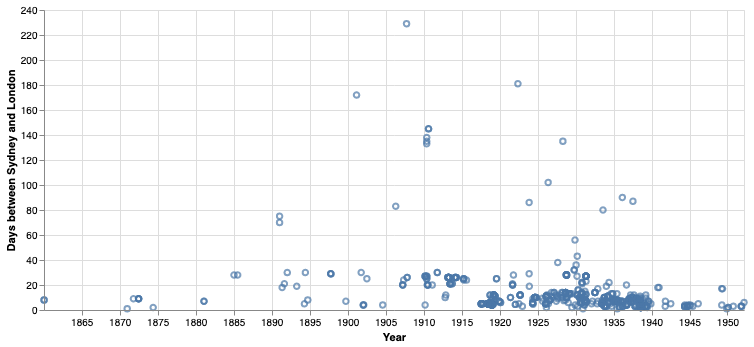

In [61]:
alt.Chart(new_df).mark_point().encode(
    x=alt.X('date:T', axis=alt.Axis(title='Year', format='%Y')),
    y=alt.Y('days', axis=alt.Axis(title='Days between Sydney and London')),
    tooltip=[alt.Tooltip('title', title='Title'), alt.Tooltip('date', title='Date')]
).properties(width=700)

To try and see what's going on lets display the number of articles per year and compare that to the median number of days extracted from the articles for that year.

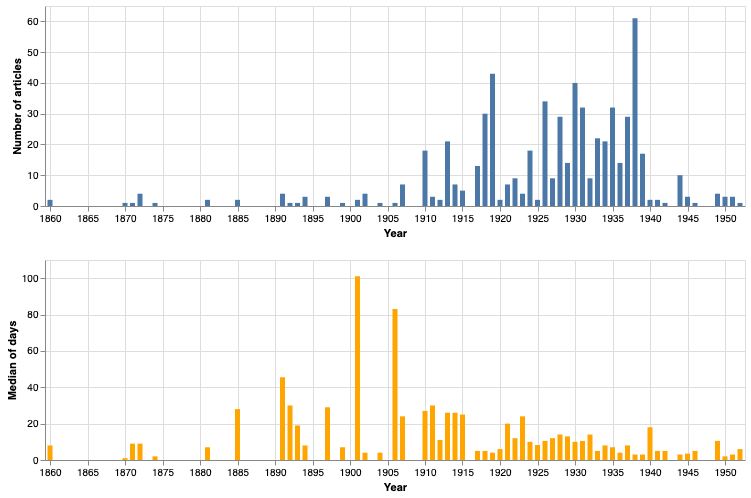

In [40]:
count = alt.Chart(new_df).mark_bar().encode(
    x=alt.X('year(date):T', title='Year'),
    y=alt.Y('count():Q', title='Number of articles'),
    tooltip=[alt.Tooltip('year(date):T', title='Year'), alt.Tooltip('count():Q', title='Number of articles')]
).properties(width=700, height=200)

median = alt.Chart(new_df).mark_bar(color='orange').encode(
    x=alt.X('year(date):T', title='Year'),
    y='median(days):Q',
    tooltip=[alt.Tooltip('year(date):T', title='Year'), alt.Tooltip('median(days):Q', title='Median number of days')]
).properties(width=700, height=200)

count & median

From the above charts we can see that there's not many articles before 1910, and there are a number of outliers (which mostly seem to be missing or overdue ships). To focus things a bit, let's create a new dataframe that limits the date range and removes the outliers.

In [70]:
filtered_df = new_df.loc[(new_df['date'] > '1910-01-01') & (new_df['days'] < 50)].copy()

Here's the median number of days using the unfiltered dataset.

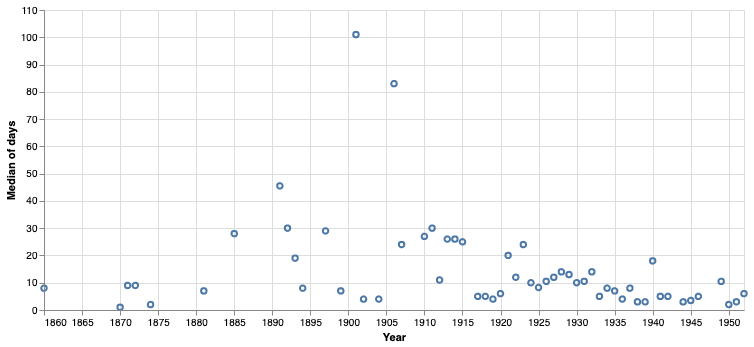

In [71]:
alt.Chart(new_df).mark_point().encode(
    x=alt.X('year(date):T', title='Year'),
    y='median(days):Q',
    tooltip=[alt.Tooltip('year(date):T', title='Year'), alt.Tooltip('median(days):Q', title='Median number of days')]
).properties(width=700)

Here's the median number of days using the filtered dataset.

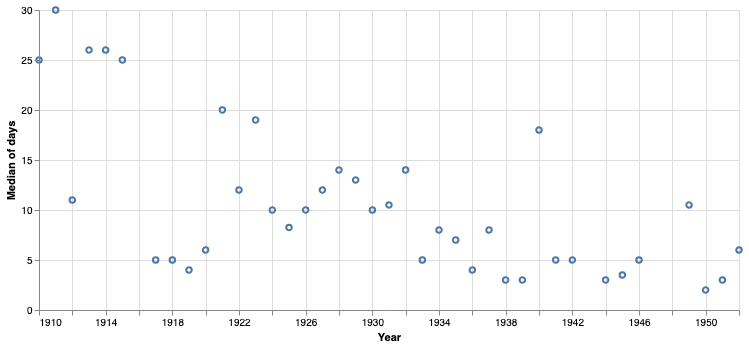

In [72]:
alt.Chart(filtered_df).mark_point().encode(
    x=alt.X('year(date):T', title='Year'),
    y='median(days):Q',
    tooltip=[alt.Tooltip('year(date):T', title='Year'), alt.Tooltip('median(days):Q', title='Median number of days')]
).properties(width=700)

The median number of days seems to show a trend. Let's see if we can visualise that trend by fitting a curve (in this case a first degree polynomial) to the complete set of data points.

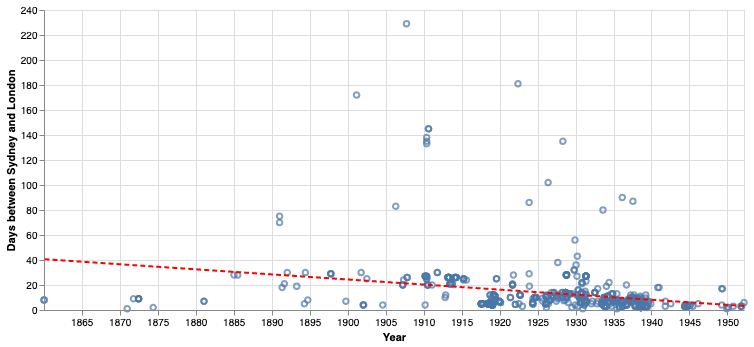

In [73]:
# See https://altair-viz.github.io/gallery/poly_fit.html for an example of creating polynomial fit plots using Altair

ts_df = new_df.copy()

# We need to convert the dates to timestamps to fit the data
ts_df['timestamp'] = ts_df['date'].apply(lambda x: x.timestamp())

# Build a dataframe with the fitted data
poly_data = pd.DataFrame({'xfit': np.linspace(ts_df['timestamp'].min(), ts_df['timestamp'].max())})
poly_data['yfit'] = np.poly1d(np.polyfit(ts_df['timestamp'], ts_df['days'], 1))(poly_data['xfit'])

# Now we can turn the fitted timestamps back into dates for charting
poly_data['xfit'] = poly_data['xfit'].apply(lambda x: datetime.datetime.fromtimestamp(x))

# Plot the points
points = alt.Chart(ts_df).mark_point().encode(
    x=alt.X('date:T', axis=alt.Axis(title='Year', format='%Y')),
    y=alt.Y('days', axis=alt.Axis(title='Days between Sydney and London')),
    tooltip=[alt.Tooltip('title', title='Title'), alt.Tooltip('date', title='Date')]
).properties(width=700)

# Plot the best fit 
polynomial_fit = alt.Chart(poly_data).mark_line(color='red', strokeDash=[5, 3]).encode(
    x='xfit',
    y='yfit'
)

points + polynomial_fit

Let's try that again with the filtered dataset.

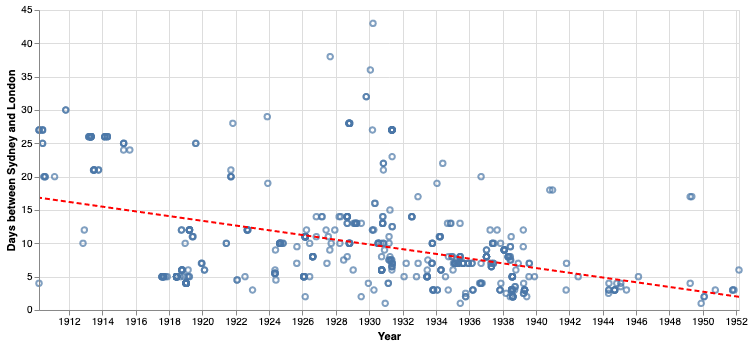

In [75]:
ts_filtered_df = filtered_df.copy()

# We need to convert the dates to timestamps to fit the data
ts_filtered_df['timestamp'] = ts_filtered_df['date'].apply(lambda x: x.timestamp())

# Build a dataframe with the fitted data
f_poly_data = pd.DataFrame({'xfit': np.linspace(ts_filtered_df['timestamp'].min(), ts_filtered_df['timestamp'].max())})
f_poly_data['yfit'] = np.poly1d(np.polyfit(ts_filtered_df['timestamp'], ts_filtered_df['days'], 1))(f_poly_data['xfit'])

# Convert timestamps to dates for charting
f_poly_data['xfit'] = f_poly_data['xfit'].apply(lambda x: datetime.datetime.fromtimestamp(x))

f_points = alt.Chart(ts_filtered_df).mark_point().encode(
    x=alt.X('date:T', axis=alt.Axis(title='Year', format='%Y')),
    y=alt.Y('days', axis=alt.Axis(title='Days between Sydney and London')),
    tooltip=[alt.Tooltip('title', title='Title'), alt.Tooltip('date', title='Date')]
).properties(width=700, height=300)

# Plot the best fit polynomials
f_polynomial_fit = alt.Chart(f_poly_data).mark_line(color='red', strokeDash=[5, 3]).encode(
    x='xfit:T',
    y='yfit'
)

f_points + f_polynomial_fit